In [1]:
import pandas as pd 
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn import tree
import os
import pydotplus

os.chdir(r"C:\Users\aman.khatri91425\Desktop\HomeCredit\UW\RGS")

# Read Data

In [2]:
df = pd.read_csv(os.getcwd()+r"\Data Files\base_dump_new2.csv")

In [3]:
df.head()

,SKP_CREDIT_CASE,DECISION_OVERALL,TIME_CREATION_DATE,PRODUCT_GOODS_TYPE,PRODUCT_CREDIT_TYPE,AMT_CREDIT,POS_MAR20_GM_EXI,DP_PCT,POS_GSPN_V2,CLIENT_EMI,...,RISK_AGRF120,RISK_AGRF150,RISK_FPD30,RISK_FSPD30,RISK_FSTPD30,RISK_FSTQPD30,RISK_FSTQPD60,FLAG_1PCT_PHANTOM,DECISION_REASON_GROUP,SCORE_CB
0,280774731,Rejected,01-11-19,c_Mob_Tab,ZERO,17598,NaN,0.267,2.0,3143,...,0,0,0,0,0,0,0,0,PRELIM_RGS,710.0
1,280774739,Approved,01-11-19,c_Mob_Tab,ZERO,11990,NaN,0.334,1.0,1291,...,1,1,0,0,0,0,0,0,PRE_RGS,664.0
2,280774750,Approved,01-11-19,c_Mob_Tab,STANDARD,11299,0.092093,0.372,NaN,1526,...,1,1,0,0,0,0,0,0,PRE_RGS,1.0
3,280774847,Approved,01-11-19,c_Mob_Tab,ZERO,13099,0.009076,0.229,3.0,2340,...,1,1,0,0,0,0,0,0,PRE_RGS,710.0
4,280774867,Approved,01-11-19,c_Mob_Tab,ZERO,10289,NaN,0.265,2.0,1838,...,1,1,0,0,0,0,0,0,PRE_RGS,709.0


# Define Key Variables

In [4]:
TARGET = 'RISK_FSTPD30'
DATE = 'TIME_CREATION_DATE'
SCORE = 'POS_MAR20_GM_EXI'
TRAIN_START_DATE = pd.datetime(2019,11,1)
TRAIN_END_DATE = pd.datetime(2020,8,1)

FEATURES = ['PRODUCT_GOODS_TYPE', 'PRODUCT_CREDIT_TYPE', 'AMT_CREDIT',
       'POS_MAR20_GM_EXI', 'DP_PCT', 'POS_GSPN_V2', 'CLIENT_EMI', 'POS_TYPE',
        'SCORE_CB']

C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  after removing the cwd from sys.path.
C:\Users\aman.khatri91425\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:5: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """


# Clean Data

In [5]:
df[DATE] = pd.to_datetime(df[DATE],format='%d-%m-%y')
df["MONTH"] = df[DATE].dt.strftime('%y-%m')

In [6]:
df = df.dropna(subset=[SCORE,'SCORE_CB','POS_GSPN_V2'])
df = df[df.DECISION_OVERALL == 'Approved']

In [7]:
CATEGORICAL_FEATURES = [key for key in dict(df[FEATURES].dtypes) if dict(df[FEATURES].dtypes)[key] in ['object']] 

In [8]:
for x in CATEGORICAL_FEATURES:
    dummy = pd.get_dummies(df[x])
    dummy.columns = [y+"_"+x for y in dummy.columns]
    df = pd.concat([df, dummy], axis=1)

In [9]:
df.MONTH.value_counts().sort_index()

19-11    15557
20-07    39910
20-08    57979
20-09    86471
20-10    73656
20-11    99348
20-12    61903
Name: MONTH, dtype: int64

In [10]:
df.columns

Index(['SKP_CREDIT_CASE', 'DECISION_OVERALL', 'TIME_CREATION_DATE',
       'PRODUCT_GOODS_TYPE', 'PRODUCT_CREDIT_TYPE', 'AMT_CREDIT',
       'POS_MAR20_GM_EXI', 'DP_PCT', 'POS_GSPN_V2', 'CLIENT_EMI', 'POS_TYPE',
       'SCORE_FEB19_WITH_CIBIL', 'RISK_AGRF30', 'RISK_AGRF60', 'RISK_AGRF90',
       'RISK_AGRF120', 'RISK_AGRF150', 'RISK_FPD30', 'RISK_FSPD30',
       'RISK_FSTPD30', 'RISK_FSTQPD30', 'RISK_FSTQPD60', 'FLAG_1PCT_PHANTOM',
       'DECISION_REASON_GROUP', 'SCORE_CB', 'MONTH', 'a_TW_PRODUCT_GOODS_TYPE',
       'c_Mob_Tab_PRODUCT_GOODS_TYPE', 'd_CP_PRODUCT_GOODS_TYPE',
       'e_HA_PRODUCT_GOODS_TYPE', '2X0_PRODUCT_CREDIT_TYPE',
       'STANDARD_PRODUCT_CREDIT_TYPE', 'ZERO_PRODUCT_CREDIT_TYPE',
       'AP_POS_TYPE', 'Aldi_POS_TYPE', 'Satellite_POS_TYPE', 'UDAAN_POS_TYPE',
       'XNA_POS_TYPE'],
      dtype='object')

In [11]:
FINAL_FEATURES = ['POS_MAR20_GM_EXI', 'DP_PCT', 'POS_GSPN_V2', 'CLIENT_EMI', 'AMT_CREDIT',
                    'a_TW_PRODUCT_GOODS_TYPE', 'c_Mob_Tab_PRODUCT_GOODS_TYPE', 'd_CP_PRODUCT_GOODS_TYPE', 
                  'e_HA_PRODUCT_GOODS_TYPE', 
                  '2X0_PRODUCT_CREDIT_TYPE', 'STANDARD_PRODUCT_CREDIT_TYPE', 'ZERO_PRODUCT_CREDIT_TYPE', 
                  'AP_POS_TYPE', 'Aldi_POS_TYPE', 'Satellite_POS_TYPE', 'UDAAN_POS_TYPE','XNA_POS_TYPE',
                'SCORE_CB']

# Train Set

In [12]:
df_train = df[(df[DATE]>=(TRAIN_START_DATE))&(df[DATE]<(TRAIN_END_DATE))]

In [13]:
df_train.shape

(55467, 38)

# Decision Tree

## Optimize tree depth

### Cross Validation Gini with Tree Depth

In [14]:
depth= []
for i in range(1,10):
    clf = DecisionTreeClassifier(max_depth=i, min_samples_leaf = 500)
    # Perform 7-fold cross validation 
    scores = cross_val_score(clf, df_train[FINAL_FEATURES], df_train[TARGET], cv=10,scoring='roc_auc',n_jobs=-1)
    depth.append((i,scores.mean()))
print(depth)

[(1, 0.58431605786498), (2, 0.6611789011213698), (3, 0.6803767733511565), (4, 0.6890101464710691), (5, 0.6911816694716485), (6, 0.6889957561484187), (7, 0.6896813734707182), (8, 0.6832676519784031), (9, 0.6780959174496537)]


# Fit model with best n

In [15]:
clf = DecisionTreeClassifier(random_state=0, max_depth=4, min_samples_leaf = 500)
clf.fit(df_train[FINAL_FEATURES], df_train[TARGET])

DecisionTreeClassifier(max_depth=4, min_samples_leaf=500, random_state=0)

In [16]:
df["PRED_PROB"]=clf.predict_proba(df[FINAL_FEATURES])[:,1]

In [17]:
# Create DOT data
dot_data = tree.export_graphviz(clf, out_file=None, 
                                feature_names=FINAL_FEATURES,  
                                class_names=TARGET, proportion = True)
# Draw graph
graph = pydotplus.graph_from_dot_data(dot_data)  

# Show graph ---Not working due to graphViz
#Image(graph.create_png())

In [18]:
print(dot_data)
# copy this to editor window on http://www.webgraphviz.com/ to create chart

digraph Tree {
node [shape=box] ;
0 [label="POS_MAR20_GM_EXI <= 0.079\ngini = 0.047\nsamples = 100.0%\nvalue = [0.976, 0.024]\nclass = R"] ;
1 [label="POS_MAR20_GM_EXI <= 0.034\ngini = 0.038\nsamples = 91.1%\nvalue = [0.981, 0.019]\nclass = R"] ;
0 -> 1 [labeldistance=2.5, labelangle=45, headlabel="True"] ;
2 [label="POS_MAR20_GM_EXI <= 0.02\ngini = 0.026\nsamples = 63.1%\nvalue = [0.987, 0.013]\nclass = R"] ;
1 -> 2 ;
3 [label="ZERO_PRODUCT_CREDIT_TYPE <= 0.5\ngini = 0.018\nsamples = 38.0%\nvalue = [0.991, 0.009]\nclass = R"] ;
2 -> 3 ;
4 [label="gini = 0.026\nsamples = 13.6%\nvalue = [0.987, 0.013]\nclass = R"] ;
3 -> 4 ;
5 [label="gini = 0.014\nsamples = 24.4%\nvalue = [0.993, 0.007]\nclass = R"] ;
3 -> 5 ;
6 [label="POS_GSPN_V2 <= 1.5\ngini = 0.038\nsamples = 25.1%\nvalue = [0.981, 0.019]\nclass = R"] ;
2 -> 6 ;
7 [label="gini = 0.024\nsamples = 8.6%\nvalue = [0.988, 0.012]\nclass = R"] ;
6 -> 7 ;
8 [label="gini = 0.045\nsamples = 16.5%\nvalue = [0.977, 0.023]\nclass = R"] ;
6 -> 8

# Variable Importance

In [25]:
clf = DecisionTreeClassifier(random_state=0, max_depth=10, min_samples_leaf = 500)
clf.fit(df_train[FINAL_FEATURES], df_train[TARGET])

DecisionTreeClassifier(max_depth=10, min_samples_leaf=500, random_state=0)

In [ ]:
df.sort_values()

In [30]:
pd.DataFrame({'FEATURES':FINAL_FEATURES, 'IMPORTANCE':clf.feature_importances_}).sort_values(by='IMPORTANCE', ascending=False)

,FEATURES,IMPORTANCE
0,POS_MAR20_GM_EXI,0.720244
17,SCORE_CB,0.077979
1,DP_PCT,0.065192
3,CLIENT_EMI,0.054662
2,POS_GSPN_V2,0.038919
13,Aldi_POS_TYPE,0.015755
11,ZERO_PRODUCT_CREDIT_TYPE,0.010139
4,AMT_CREDIT,0.006487
12,AP_POS_TYPE,0.005616
10,STANDARD_PRODUCT_CREDIT_TYPE,0.005008


Feature: 0, Score: 0.86281
Feature: 1, Score: 0.01492
Feature: 2, Score: 0.03833
Feature: 3, Score: 0.03997
Feature: 4, Score: 0.00000
Feature: 5, Score: 0.00000
Feature: 6, Score: 0.00000
Feature: 7, Score: 0.00000
Feature: 8, Score: 0.00000
Feature: 9, Score: 0.00000
Feature: 10, Score: 0.00000
Feature: 11, Score: 0.00799
Feature: 12, Score: 0.00000
Feature: 13, Score: 0.00000
Feature: 14, Score: 0.00000
Feature: 15, Score: 0.00000
Feature: 16, Score: 0.00000
Feature: 17, Score: 0.03599


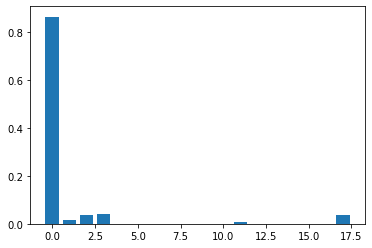

In [20]:
from matplotlib import pyplot
# define dataset
# get importance
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature: %0d, Score: %.5f' % (i,v))
# plot feature importance
pyplot.bar([x for x in range(len(importance))], importance)
pyplot.show()

# Archieve

# SQL Script

In [28]:
from sklearn.tree import export_text

In [ ]:
def get_lineage(tree, feature_names):
     left      = tree.tree_.children_left
     right     = tree.tree_.children_right
     threshold = tree.tree_.threshold
     features  = [feature_names[i] for i in tree.tree_.feature]

     # get ids of child nodes
     idx = np.argwhere(left == -1)[:,0]     

     def recurse(left, right, child, lineage=None):          
          if lineage is None:
               lineage = [child]
          if child in left:
               parent = np.where(left == child)[0].item()
               split = 'l'
          else:
               parent = np.where(right == child)[0].item()
               split = 'r'

          lineage.append((parent, split, threshold[parent], features[parent]))

          if parent == 0:
               lineage.reverse()
               return lineage
          else:
               return recurse(left, right, parent, lineage)

     for child in idx:
          for node in recurse(left, right, child):
               print node

In [36]:
def get_code(tree, feature_names, tabdepth=0):
    left      = tree.tree_.children_left
    right     = tree.tree_.children_right
    threshold = tree.tree_.threshold
    features  = [feature_names[i] for i in tree.tree_.feature]
    value = tree.tree_.value
#     print("AK",left)
#     print("AK",right)
#     print("AK",threshold)
#     print("AK",features)
#     print("AK",value)
    
    

    def recurse(left, right, threshold, features, node, tabdepth=0):
            if (threshold[node] != -2):
                    print('\t' * tabdepth)
                    print("if ( " + features[node] + " <= " + str(threshold[node]) + " ) {")
                    if left[node] != -1:
                            recurse (left, right, threshold, features,left[node], tabdepth+1)
                    print('\t' * tabdepth)
                    print ("} else {")
                    if right[node] != -1:
                            recurse (left, right, threshold, features,right[node], tabdepth+1)
                    print ('\t' * tabdepth)
                    print ("}")
            else:
                    print ('\t' * tabdepth)
                    print ("return " + str(value[node]))

    recurse(left, right, threshold, features, 0)

In [37]:
clf = DecisionTreeClassifier(random_state=0, max_depth=2, min_samples_leaf = 500)
clf.fit(df_train[FINAL_FEATURES], df_train[TARGET])

DecisionTreeClassifier(max_depth=2, min_samples_leaf=500, random_state=0)

In [38]:
get_code(clf, FINAL_FEATURES)

AK [ 1  2 -1 -1  5 -1 -1]
AK [ 4  3 -1 -1  6 -1 -1]
AK [ 0.07930014  0.03438504 -2.         -2.          0.18095641 -2.
 -2.        ]
AK ['POS_MAR20_GM_EXI', 'POS_MAR20_GM_EXI', 'XNA_POS_TYPE', 'XNA_POS_TYPE', 'POS_MAR20_GM_EXI', 'XNA_POS_TYPE', 'XNA_POS_TYPE']
AK [[[54141.  1326.]]

 [[49556.   976.]]

 [[34553.   460.]]

 [[15003.   516.]]

 [[ 4585.   350.]]

 [[ 4154.   271.]]

 [[  431.    79.]]]

if ( POS_MAR20_GM_EXI <= 0.07930013537406921 ) {
	
if ( POS_MAR20_GM_EXI <= 0.034385040402412415 ) {
		
return [[34553.   460.]]
	
} else {
		
return [[15003.   516.]]
	
}

} else {
	
if ( POS_MAR20_GM_EXI <= 0.1809564083814621 ) {
		
return [[4154.  271.]]
	
} else {
		
return [[431.  79.]]
	
}

}


# MOM Gini

In [334]:
# gini_dic = {}
# predictor_list = []
# target_variable = TARGET
# for x in df["MONTH"].unique():
#     try:
#         if "MONTH" not in gini_dic:
#             gini_dic["MONTH"] = []
#         if "GM" not in gini_dic: 
#             gini_dic["GM"] = []
#         if "RGS" not in gini_dic: 
#             gini_dic["RGS"] = []
        
#         gini_dic["GM"].append((2*roc_auc_score(df[df["MONTH"]==x][target_variable],df[df["MONTH"]==x][SCORE])-1)*100)
#         gini_dic["RGS"].append((2*roc_auc_score(df[df["MONTH"]==x][target_variable],df[df["MONTH"]==x]["PRED_PROB"])-1)*100)
#         gini_dic["MONTH"].append(x)
#     except: 
#         print("ERROR")

# gini_df = pd.DataFrame(gini_dic)
# gini_df.sort_values(by = "MONTH",inplace = True)
# gini_df.reset_index(inplace = True)

In [335]:
# import matplotlib.pyplot as plt
# fig = plt.figure(figsize = (10,5))
# ax1 = fig.add_subplot(1, 1, 1)
# ax1.plot(gini_df["MONTH"],gini_df["GM"], marker='o', scaley = False, label = "GM")
# ax1.plot(gini_df["MONTH"],gini_df["RGS"], marker='o', scaley = False, label = "RGS")
# # ax1.plot(gini_df["MONTH_STR"],gini_df[combined_score_only_fnf_flag], marker='o', scaley = False, label = combined_score_only_fnf_flag)
# # for y in predictor_list:
# #     ax1.plot(gini_df["MONTH_STR"],gini_df[y], marker='o', scaley = False, label = y)


# for i, txt in enumerate(gini_df["GM"]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["GM"][i]-0.8))
# for i, txt in enumerate(gini_df["RGS"]):
#     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH"][i], gini_df["RGS"][i]+1.2))
    
# # for i, txt in enumerate(gini_df[combined_score_only_fnf_flag]):
# #     plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[combined_score_only_fnf_flag][i]+1.6))

# # for y in predictor_list:
# #     for i, txt in enumerate(gini_df[y]):
# #         plt.annotate("{:.1f}".format(txt), (gini_df["MONTH_STR"][i], gini_df[y][i]+1))

    
# plt.legend(loc='lower right', borderaxespad=0.1)
# plt.ylim(30,50)
# plt.ylabel("GINI")
# plt.xlabel("MONTH")
# plt.yticks(np.arange(30,50,2))
# ax1.set_title("MOM Gini (Approved) With Risk Predictors:")
# plt.show()